In [1]:
import torch
from torchvision import datasets, transforms
from torcheval.metrics import BinaryAccuracy
import numpy as np
from PIL import Image

data_train = datasets.MNIST(root="./dataset",train=True,download=True,transform=transforms.ToTensor())
data_test = datasets.MNIST(root="./dataset",train=False,download=True,transform=transforms.ToTensor())

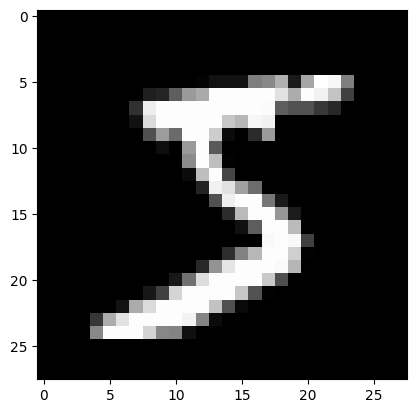

In [2]:
from matplotlib import pyplot as plt

image, label = data_train[0]

plt.imshow(image.squeeze().numpy(),cmap='gray')
plt.show()

In [3]:
from torch.utils.data import dataset, DataLoader

train_dataloader = DataLoader(data_train,batch_size=512,shuffle=True)
test_dataloader = DataLoader(data_test,batch_size=256,shuffle=True)

In [4]:
import torch.nn as nn

class HiddenSoftMaxNet(nn.Module):
    
    def __init__(self,hidden_layer:list=[]):
        super(HiddenSoftMaxNet, self).__init__()
        
        self.layers=nn.ModuleList()
        
        if len(hidden_layer) == 0:
            self.fc.append(nn.Linear(784,10))
        else :
            input_current = 784
            
            for num_class in hidden_layer :
                self.layers.append(nn.Sequential(
                    nn.Linear(input_current,num_class),
                    nn.LeakyReLU()
                ))
                input_current = num_class
                
            self.layers.append(nn.Sequential(
                nn.Linear(input_current,10),
                nn.Softmax(1)
            ))
            
        for module in self.modules():
            if isinstance(module,nn.Linear):
                nn.init.kaiming_uniform_(module.weight.data,nonlinearity='relu')
        
    def forward(self,input):
        
        for layer in self.layers:
            
            input = layer(input)
            
        output = input
        
        return output
    
net = HiddenSoftMaxNet([128,64,32]).cuda()

In [5]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(),lr=0.01)

loss_fc = nn.CrossEntropyLoss()

In [6]:
from torcheval.metrics import MulticlassAccuracy

In [7]:
x = torch.randn([18,784]).cuda()
print(net(x).shape)

torch.Size([18, 10])


In [8]:
epochs = 200
metric = MulticlassAccuracy()
from tqdm import tqdm

for epoch in range(1,epochs+1):

    loss_sum = 0.0

    for (train_features,train_labels) in tqdm(train_dataloader) :

        epoch_y = net(train_features.cuda().view((-1,784)))
        loss = loss_fc(epoch_y,train_labels.cuda()) ## cross entroy loss에 잘못된 값을 넣고 잇었군요...
        loss_sum += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    for (test_features,test_labels) in tqdm(test_dataloader) :
        
        epoch_test_y = net(test_features.cuda().view((-1,784)))
        epoch_class_y = torch.argmax(epoch_test_y,dim=-1)

        metric.update(epoch_class_y,test_labels.cuda())
        
    acc = metric.compute()

    loss = loss_sum / len(train_dataloader)

    print('Epoch {:4d}/{} train_loss: {:.6f} acc: {:.6f}'.format(
        epoch, epochs, loss, acc
    ))

    if loss < 0.1 :
        break

100%|██████████| 40/40 [00:00<00:00, 42.25it/s]


Epoch    1/200 train_loss: 2.301000 acc: 0.189300


100%|██████████| 40/40 [00:00<00:00, 43.65it/s]


Epoch    2/200 train_loss: 2.290203 acc: 0.196800


100%|██████████| 40/40 [00:00<00:00, 40.44it/s]


Epoch    3/200 train_loss: 2.271384 acc: 0.201133


100%|██████████| 40/40 [00:00<00:00, 44.56it/s]


Epoch    4/200 train_loss: 2.245191 acc: 0.210775


100%|██████████| 40/40 [00:00<00:00, 43.79it/s]


Epoch    5/200 train_loss: 2.219081 acc: 0.225500


100%|██████████| 40/40 [00:00<00:00, 43.06it/s]


Epoch    6/200 train_loss: 2.192679 acc: 0.242267


100%|██████████| 40/40 [00:00<00:00, 44.47it/s]


Epoch    7/200 train_loss: 2.163885 acc: 0.262000


100%|██████████| 40/40 [00:00<00:00, 44.56it/s]


Epoch    8/200 train_loss: 2.129057 acc: 0.284975


100%|██████████| 40/40 [00:00<00:00, 43.73it/s]


Epoch    9/200 train_loss: 2.082518 acc: 0.312422


100%|██████████| 40/40 [00:00<00:00, 43.48it/s]


Epoch   10/200 train_loss: 2.022209 acc: 0.337690


100%|██████████| 40/40 [00:00<00:00, 42.75it/s]


Epoch   11/200 train_loss: 1.972441 acc: 0.362173


100%|██████████| 40/40 [00:00<00:00, 43.15it/s]


Epoch   12/200 train_loss: 1.932238 acc: 0.384700


100%|██████████| 40/40 [00:00<00:00, 44.22it/s]


Epoch   13/200 train_loss: 1.886539 acc: 0.410054


100%|██████████| 40/40 [00:00<00:00, 43.84it/s]


Epoch   14/200 train_loss: 1.840237 acc: 0.432893


100%|██████████| 40/40 [00:00<00:00, 44.67it/s]


Epoch   15/200 train_loss: 1.807066 acc: 0.454147


100%|██████████| 40/40 [00:00<00:00, 43.60it/s]


Epoch   16/200 train_loss: 1.778225 acc: 0.474981


100%|██████████| 40/40 [00:00<00:00, 43.85it/s]


Epoch   17/200 train_loss: 1.748717 acc: 0.495082


100%|██████████| 40/40 [00:00<00:00, 43.37it/s]


Epoch   18/200 train_loss: 1.723144 acc: 0.513794


100%|██████████| 40/40 [00:00<00:00, 44.58it/s]


Epoch   19/200 train_loss: 1.702197 acc: 0.531279


100%|██████████| 40/40 [00:00<00:00, 43.89it/s]


Epoch   20/200 train_loss: 1.684680 acc: 0.547655


100%|██████████| 40/40 [00:00<00:00, 43.51it/s]


Epoch   21/200 train_loss: 1.669954 acc: 0.562843


100%|██████████| 40/40 [00:00<00:00, 43.06it/s]


Epoch   22/200 train_loss: 1.657462 acc: 0.577009


100%|██████████| 40/40 [00:00<00:00, 43.26it/s]


Epoch   23/200 train_loss: 1.646723 acc: 0.590204


100%|██████████| 40/40 [00:00<00:00, 43.09it/s]


Epoch   24/200 train_loss: 1.637440 acc: 0.602529


100%|██████████| 40/40 [00:00<00:00, 43.47it/s]


Epoch   25/200 train_loss: 1.629922 acc: 0.614048


100%|██████████| 40/40 [00:00<00:00, 44.19it/s]


Epoch   26/200 train_loss: 1.623827 acc: 0.624712


100%|██████████| 40/40 [00:00<00:00, 43.34it/s]


Epoch   27/200 train_loss: 1.617527 acc: 0.634711


100%|██████████| 40/40 [00:00<00:00, 41.85it/s]


Epoch   28/200 train_loss: 1.612505 acc: 0.644104


100%|██████████| 40/40 [00:00<00:00, 41.33it/s]


Epoch   29/200 train_loss: 1.608091 acc: 0.652834


100%|██████████| 40/40 [00:01<00:00, 36.88it/s]


Epoch   30/200 train_loss: 1.604366 acc: 0.661080


100%|██████████| 40/40 [00:00<00:00, 42.10it/s]


Epoch   31/200 train_loss: 1.600364 acc: 0.668829


100%|██████████| 40/40 [00:00<00:00, 43.95it/s]


Epoch   32/200 train_loss: 1.597570 acc: 0.676131


100%|██████████| 40/40 [00:00<00:00, 42.39it/s]


Epoch   33/200 train_loss: 1.594798 acc: 0.683033


100%|██████████| 40/40 [00:00<00:00, 41.90it/s]


Epoch   34/200 train_loss: 1.591890 acc: 0.689582


100%|██████████| 40/40 [00:00<00:00, 41.04it/s]


Epoch   35/200 train_loss: 1.589504 acc: 0.695746


100%|██████████| 40/40 [00:00<00:00, 42.02it/s]


Epoch   36/200 train_loss: 1.586984 acc: 0.701600


100%|██████████| 40/40 [00:00<00:00, 42.48it/s]


Epoch   37/200 train_loss: 1.585063 acc: 0.707176


100%|██████████| 40/40 [00:00<00:00, 43.04it/s]


Epoch   38/200 train_loss: 1.582727 acc: 0.712468


100%|██████████| 40/40 [00:00<00:00, 43.53it/s]


Epoch   39/200 train_loss: 1.581031 acc: 0.717518


100%|██████████| 40/40 [00:00<00:00, 44.09it/s]


Epoch   40/200 train_loss: 1.579188 acc: 0.722327


100%|██████████| 40/40 [00:00<00:00, 43.52it/s]


Epoch   41/200 train_loss: 1.577654 acc: 0.726917


100%|██████████| 40/40 [00:00<00:00, 43.11it/s]


Epoch   42/200 train_loss: 1.576394 acc: 0.731319


100%|██████████| 40/40 [00:00<00:00, 43.97it/s]


Epoch   43/200 train_loss: 1.574736 acc: 0.735514


100%|██████████| 40/40 [00:00<00:00, 42.58it/s]


Epoch   44/200 train_loss: 1.573674 acc: 0.739539


100%|██████████| 40/40 [00:00<00:00, 44.05it/s]


Epoch   45/200 train_loss: 1.572128 acc: 0.743387


100%|██████████| 40/40 [00:00<00:00, 43.78it/s]


Epoch   46/200 train_loss: 1.570694 acc: 0.747076


100%|██████████| 40/40 [00:00<00:00, 44.24it/s]


Epoch   47/200 train_loss: 1.569471 acc: 0.750623


100%|██████████| 40/40 [00:00<00:00, 44.42it/s]


Epoch   48/200 train_loss: 1.568394 acc: 0.754046


100%|██████████| 40/40 [00:00<00:00, 42.90it/s]


Epoch   49/200 train_loss: 1.567575 acc: 0.757351


100%|██████████| 40/40 [00:00<00:00, 42.98it/s]


Epoch   50/200 train_loss: 1.566420 acc: 0.760542


100%|██████████| 40/40 [00:00<00:00, 41.93it/s]


Epoch   51/200 train_loss: 1.565357 acc: 0.763608


100%|██████████| 40/40 [00:00<00:00, 40.23it/s]


Epoch   52/200 train_loss: 1.564459 acc: 0.766550


100%|██████████| 40/40 [00:00<00:00, 42.88it/s]


Epoch   53/200 train_loss: 1.563451 acc: 0.769411


100%|██████████| 40/40 [00:00<00:00, 43.76it/s]


Epoch   54/200 train_loss: 1.562853 acc: 0.772180


100%|██████████| 40/40 [00:00<00:00, 41.39it/s]


Epoch   55/200 train_loss: 1.561628 acc: 0.774864


100%|██████████| 40/40 [00:00<00:00, 42.46it/s]


Epoch   56/200 train_loss: 1.560894 acc: 0.777436


100%|██████████| 40/40 [00:00<00:00, 42.53it/s]


Epoch   57/200 train_loss: 1.560073 acc: 0.779925


100%|██████████| 40/40 [00:00<00:00, 43.58it/s]


Epoch   58/200 train_loss: 1.559142 acc: 0.782343


100%|██████████| 40/40 [00:00<00:00, 43.64it/s]


Epoch   59/200 train_loss: 1.558847 acc: 0.784702


100%|██████████| 40/40 [00:00<00:00, 43.92it/s]


Epoch   60/200 train_loss: 1.557788 acc: 0.786960


100%|██████████| 40/40 [00:00<00:00, 43.18it/s]


Epoch   61/200 train_loss: 1.557202 acc: 0.789148


100%|██████████| 40/40 [00:01<00:00, 38.10it/s]


Epoch   62/200 train_loss: 1.556455 acc: 0.791287


100%|██████████| 40/40 [00:00<00:00, 42.68it/s]


Epoch   63/200 train_loss: 1.555847 acc: 0.793351


100%|██████████| 40/40 [00:00<00:00, 42.59it/s]


Epoch   64/200 train_loss: 1.555107 acc: 0.795359


100%|██████████| 40/40 [00:00<00:00, 42.67it/s]


Epoch   65/200 train_loss: 1.554418 acc: 0.797320


100%|██████████| 40/40 [00:00<00:00, 43.30it/s]


Epoch   66/200 train_loss: 1.554023 acc: 0.799227


100%|██████████| 40/40 [00:00<00:00, 42.37it/s]


Epoch   67/200 train_loss: 1.553141 acc: 0.801073


100%|██████████| 40/40 [00:00<00:00, 42.91it/s]


Epoch   68/200 train_loss: 1.552921 acc: 0.802865


100%|██████████| 40/40 [00:00<00:00, 43.68it/s]


Epoch   69/200 train_loss: 1.552299 acc: 0.804614


100%|██████████| 40/40 [00:00<00:00, 43.43it/s]


Epoch   70/200 train_loss: 1.551727 acc: 0.806327


100%|██████████| 40/40 [00:00<00:00, 43.14it/s]


Epoch   71/200 train_loss: 1.551037 acc: 0.807990


100%|██████████| 40/40 [00:00<00:00, 43.32it/s]


Epoch   72/200 train_loss: 1.550659 acc: 0.809615


100%|██████████| 40/40 [00:00<00:00, 43.21it/s]


Epoch   73/200 train_loss: 1.550051 acc: 0.811201


100%|██████████| 40/40 [00:00<00:00, 43.28it/s]


Epoch   74/200 train_loss: 1.549400 acc: 0.812746


100%|██████████| 40/40 [00:00<00:00, 41.05it/s]


Epoch   75/200 train_loss: 1.548994 acc: 0.814268


100%|██████████| 40/40 [00:00<00:00, 43.60it/s]


Epoch   76/200 train_loss: 1.548577 acc: 0.815741


100%|██████████| 40/40 [00:00<00:00, 43.50it/s]


Epoch   77/200 train_loss: 1.548424 acc: 0.817177


100%|██████████| 40/40 [00:00<00:00, 43.15it/s]


Epoch   78/200 train_loss: 1.547742 acc: 0.818591


100%|██████████| 40/40 [00:00<00:00, 43.02it/s]


Epoch   79/200 train_loss: 1.547457 acc: 0.819966


100%|██████████| 40/40 [00:00<00:00, 42.56it/s]


Epoch   80/200 train_loss: 1.546876 acc: 0.821304


100%|██████████| 40/40 [00:00<00:00, 42.81it/s]


Epoch   81/200 train_loss: 1.546171 acc: 0.822612


100%|██████████| 40/40 [00:00<00:00, 43.48it/s]


Epoch   82/200 train_loss: 1.546005 acc: 0.823900


100%|██████████| 40/40 [00:00<00:00, 42.67it/s]


Epoch   83/200 train_loss: 1.545425 acc: 0.825161


100%|██████████| 40/40 [00:00<00:00, 42.50it/s]


Epoch   84/200 train_loss: 1.545212 acc: 0.826389


100%|██████████| 40/40 [00:00<00:00, 43.19it/s]


Epoch   85/200 train_loss: 1.544895 acc: 0.827596


100%|██████████| 40/40 [00:00<00:00, 43.73it/s]


Epoch   86/200 train_loss: 1.544235 acc: 0.828772


100%|██████████| 40/40 [00:00<00:00, 42.53it/s]


Epoch   87/200 train_loss: 1.544011 acc: 0.829932


100%|██████████| 40/40 [00:00<00:00, 42.73it/s]


Epoch   88/200 train_loss: 1.543528 acc: 0.831069


100%|██████████| 40/40 [00:00<00:00, 42.68it/s]


Epoch   89/200 train_loss: 1.543369 acc: 0.832184


100%|██████████| 40/40 [00:00<00:00, 41.32it/s]


Epoch   90/200 train_loss: 1.542778 acc: 0.833273


100%|██████████| 40/40 [00:00<00:00, 42.63it/s]


Epoch   91/200 train_loss: 1.542435 acc: 0.834344


100%|██████████| 40/40 [00:00<00:00, 42.03it/s]


Epoch   92/200 train_loss: 1.541879 acc: 0.835390


100%|██████████| 40/40 [00:00<00:00, 42.48it/s]


Epoch   93/200 train_loss: 1.541649 acc: 0.836419


100%|██████████| 40/40 [00:00<00:00, 43.33it/s]


Epoch   94/200 train_loss: 1.541318 acc: 0.837436


100%|██████████| 40/40 [00:00<00:00, 42.00it/s]


Epoch   95/200 train_loss: 1.540888 acc: 0.838434


100%|██████████| 40/40 [00:00<00:00, 43.71it/s]


Epoch   96/200 train_loss: 1.540637 acc: 0.839407


100%|██████████| 40/40 [00:00<00:00, 43.80it/s]


Epoch   97/200 train_loss: 1.540278 acc: 0.840367


100%|██████████| 40/40 [00:00<00:00, 42.91it/s]


Epoch   98/200 train_loss: 1.539833 acc: 0.841302


100%|██████████| 40/40 [00:00<00:00, 42.93it/s]


Epoch   99/200 train_loss: 1.539536 acc: 0.842229


100%|██████████| 40/40 [00:00<00:00, 41.55it/s]


Epoch  100/200 train_loss: 1.539137 acc: 0.843137


100%|██████████| 40/40 [00:00<00:00, 43.47it/s]


Epoch  101/200 train_loss: 1.538835 acc: 0.844031


100%|██████████| 40/40 [00:00<00:00, 43.76it/s]


Epoch  102/200 train_loss: 1.538496 acc: 0.844901


100%|██████████| 40/40 [00:00<00:00, 42.86it/s]


Epoch  103/200 train_loss: 1.538187 acc: 0.845765


100%|██████████| 40/40 [00:00<00:00, 42.80it/s]


Epoch  104/200 train_loss: 1.537950 acc: 0.846614


100%|██████████| 40/40 [00:00<00:00, 44.16it/s]


Epoch  105/200 train_loss: 1.537292 acc: 0.847447


100%|██████████| 40/40 [00:00<00:00, 44.06it/s]


Epoch  106/200 train_loss: 1.537075 acc: 0.848267


100%|██████████| 40/40 [00:00<00:00, 43.51it/s]


Epoch  107/200 train_loss: 1.537057 acc: 0.849075


100%|██████████| 40/40 [00:00<00:00, 41.95it/s]


Epoch  108/200 train_loss: 1.536635 acc: 0.849867


100%|██████████| 40/40 [00:00<00:00, 42.31it/s]


Epoch  109/200 train_loss: 1.536611 acc: 0.850649


100%|██████████| 40/40 [00:00<00:00, 42.36it/s]


Epoch  110/200 train_loss: 1.536060 acc: 0.851416


100%|██████████| 40/40 [00:00<00:00, 43.20it/s]


Epoch  111/200 train_loss: 1.535529 acc: 0.852168


100%|██████████| 40/40 [00:00<00:00, 43.37it/s]


Epoch  112/200 train_loss: 1.535710 acc: 0.852912


100%|██████████| 40/40 [00:00<00:00, 42.51it/s]


Epoch  113/200 train_loss: 1.535143 acc: 0.853643


100%|██████████| 40/40 [00:00<00:00, 41.81it/s]


Epoch  114/200 train_loss: 1.534719 acc: 0.854364


100%|██████████| 40/40 [00:00<00:00, 43.14it/s]


Epoch  115/200 train_loss: 1.534868 acc: 0.855070


100%|██████████| 40/40 [00:00<00:00, 44.61it/s]


Epoch  116/200 train_loss: 1.534668 acc: 0.855764


100%|██████████| 40/40 [00:00<00:00, 43.57it/s]


Epoch  117/200 train_loss: 1.533973 acc: 0.856447


100%|██████████| 40/40 [00:00<00:00, 43.55it/s]


Epoch  118/200 train_loss: 1.533930 acc: 0.857121


100%|██████████| 40/40 [00:00<00:00, 42.81it/s]


Epoch  119/200 train_loss: 1.533672 acc: 0.857785


100%|██████████| 40/40 [00:00<00:00, 41.98it/s]


Epoch  120/200 train_loss: 1.533440 acc: 0.858441


100%|██████████| 40/40 [00:00<00:00, 41.89it/s]


Epoch  121/200 train_loss: 1.532818 acc: 0.859089


100%|██████████| 40/40 [00:00<00:00, 43.15it/s]


Epoch  122/200 train_loss: 1.532689 acc: 0.859725


100%|██████████| 40/40 [00:00<00:00, 43.61it/s]


Epoch  123/200 train_loss: 1.532469 acc: 0.860345


100%|██████████| 40/40 [00:00<00:00, 42.46it/s]


Epoch  124/200 train_loss: 1.532649 acc: 0.860956


100%|██████████| 40/40 [00:00<00:00, 42.49it/s]


Epoch  125/200 train_loss: 1.532177 acc: 0.861566


100%|██████████| 40/40 [00:00<00:00, 43.38it/s]


Epoch  126/200 train_loss: 1.531794 acc: 0.862163


100%|██████████| 40/40 [00:00<00:00, 43.28it/s]


Epoch  127/200 train_loss: 1.531605 acc: 0.862751


100%|██████████| 40/40 [00:00<00:00, 42.97it/s]


Epoch  128/200 train_loss: 1.531558 acc: 0.863334


100%|██████████| 40/40 [00:00<00:00, 41.10it/s]


Epoch  129/200 train_loss: 1.531149 acc: 0.863909


100%|██████████| 40/40 [00:00<00:00, 40.42it/s]


Epoch  130/200 train_loss: 1.530777 acc: 0.864475


100%|██████████| 40/40 [00:00<00:00, 42.97it/s]


Epoch  131/200 train_loss: 1.530526 acc: 0.865037


100%|██████████| 40/40 [00:00<00:00, 42.93it/s]


Epoch  132/200 train_loss: 1.530528 acc: 0.865592


100%|██████████| 40/40 [00:00<00:00, 42.80it/s]


Epoch  133/200 train_loss: 1.529995 acc: 0.866138


100%|██████████| 40/40 [00:00<00:00, 41.16it/s]


Epoch  134/200 train_loss: 1.530055 acc: 0.866675


100%|██████████| 40/40 [00:00<00:00, 43.02it/s]


Epoch  135/200 train_loss: 1.529624 acc: 0.867207


100%|██████████| 40/40 [00:00<00:00, 44.36it/s]


Epoch  136/200 train_loss: 1.529510 acc: 0.867731


100%|██████████| 40/40 [00:00<00:00, 43.64it/s]


Epoch  137/200 train_loss: 1.529198 acc: 0.868250


100%|██████████| 40/40 [00:00<00:00, 41.99it/s]


Epoch  138/200 train_loss: 1.528995 acc: 0.868765


100%|██████████| 40/40 [00:00<00:00, 42.41it/s]


Epoch  139/200 train_loss: 1.529010 acc: 0.869280


100%|██████████| 40/40 [00:00<00:00, 40.73it/s]


Epoch  140/200 train_loss: 1.528511 acc: 0.869786


100%|██████████| 40/40 [00:00<00:00, 41.95it/s]


Epoch  141/200 train_loss: 1.528537 acc: 0.870281


100%|██████████| 40/40 [00:00<00:00, 41.34it/s]


Epoch  142/200 train_loss: 1.527961 acc: 0.870763


100%|██████████| 40/40 [00:00<00:00, 40.11it/s]


Epoch  143/200 train_loss: 1.527988 acc: 0.871243


100%|██████████| 40/40 [00:00<00:00, 43.13it/s]


Epoch  144/200 train_loss: 1.527853 acc: 0.871724


100%|██████████| 40/40 [00:00<00:00, 42.86it/s]


Epoch  145/200 train_loss: 1.527400 acc: 0.872192


100%|██████████| 40/40 [00:00<00:00, 44.22it/s]


Epoch  146/200 train_loss: 1.527300 acc: 0.872653


100%|██████████| 40/40 [00:00<00:00, 42.84it/s]


Epoch  147/200 train_loss: 1.526974 acc: 0.873112


100%|██████████| 40/40 [00:00<00:00, 43.23it/s]


Epoch  148/200 train_loss: 1.526635 acc: 0.873570


100%|██████████| 40/40 [00:00<00:00, 41.84it/s]


Epoch  149/200 train_loss: 1.526692 acc: 0.874019


100%|██████████| 40/40 [00:00<00:00, 42.51it/s]


Epoch  150/200 train_loss: 1.526628 acc: 0.874462


100%|██████████| 40/40 [00:00<00:00, 42.99it/s]


Epoch  151/200 train_loss: 1.526285 acc: 0.874899


100%|██████████| 40/40 [00:00<00:00, 43.36it/s]


Epoch  152/200 train_loss: 1.525881 acc: 0.875332


100%|██████████| 40/40 [00:00<00:00, 43.95it/s]


Epoch  153/200 train_loss: 1.525778 acc: 0.875761


100%|██████████| 40/40 [00:00<00:00, 43.56it/s]


Epoch  154/200 train_loss: 1.525572 acc: 0.876181


100%|██████████| 40/40 [00:00<00:00, 43.91it/s]


Epoch  155/200 train_loss: 1.525360 acc: 0.876599


100%|██████████| 40/40 [00:00<00:00, 43.49it/s]


Epoch  156/200 train_loss: 1.525143 acc: 0.877012


100%|██████████| 40/40 [00:00<00:00, 41.98it/s]


Epoch  157/200 train_loss: 1.525086 acc: 0.877423


100%|██████████| 40/40 [00:01<00:00, 36.58it/s]


Epoch  158/200 train_loss: 1.525049 acc: 0.877830


100%|██████████| 40/40 [00:00<00:00, 42.52it/s]


Epoch  159/200 train_loss: 1.524767 acc: 0.878231


100%|██████████| 40/40 [00:00<00:00, 40.71it/s]


Epoch  160/200 train_loss: 1.524818 acc: 0.878627


100%|██████████| 40/40 [00:00<00:00, 43.46it/s]


Epoch  161/200 train_loss: 1.524187 acc: 0.879019


100%|██████████| 40/40 [00:00<00:00, 40.28it/s]


Epoch  162/200 train_loss: 1.524008 acc: 0.879406


100%|██████████| 40/40 [00:00<00:00, 44.24it/s]


Epoch  163/200 train_loss: 1.523965 acc: 0.879790


100%|██████████| 40/40 [00:00<00:00, 43.76it/s]


Epoch  164/200 train_loss: 1.523814 acc: 0.880170


100%|██████████| 40/40 [00:00<00:00, 42.81it/s]


Epoch  165/200 train_loss: 1.523336 acc: 0.880550


100%|██████████| 40/40 [00:00<00:00, 43.88it/s]


Epoch  166/200 train_loss: 1.523287 acc: 0.880922


100%|██████████| 40/40 [00:00<00:00, 42.33it/s]


Epoch  167/200 train_loss: 1.523196 acc: 0.881288


100%|██████████| 40/40 [00:00<00:00, 42.57it/s]


Epoch  168/200 train_loss: 1.523239 acc: 0.881648


100%|██████████| 40/40 [00:00<00:00, 41.38it/s]


Epoch  169/200 train_loss: 1.522948 acc: 0.882003


100%|██████████| 40/40 [00:00<00:00, 42.18it/s]


Epoch  170/200 train_loss: 1.522565 acc: 0.882361


100%|██████████| 40/40 [00:00<00:00, 42.66it/s]


Epoch  171/200 train_loss: 1.522489 acc: 0.882718


100%|██████████| 40/40 [00:00<00:00, 43.45it/s]


Epoch  172/200 train_loss: 1.522071 acc: 0.883067


100%|██████████| 40/40 [00:00<00:00, 43.27it/s]


Epoch  173/200 train_loss: 1.522258 acc: 0.883413


100%|██████████| 40/40 [00:00<00:00, 43.10it/s]


Epoch  174/200 train_loss: 1.522110 acc: 0.883758


100%|██████████| 40/40 [00:00<00:00, 42.66it/s]


Epoch  175/200 train_loss: 1.521894 acc: 0.884100


100%|██████████| 40/40 [00:00<00:00, 42.08it/s]


Epoch  176/200 train_loss: 1.521874 acc: 0.884433


100%|██████████| 40/40 [00:00<00:00, 42.74it/s]


Epoch  177/200 train_loss: 1.521370 acc: 0.884763


100%|██████████| 40/40 [00:00<00:00, 41.14it/s]


Epoch  178/200 train_loss: 1.521586 acc: 0.885092


100%|██████████| 40/40 [00:00<00:00, 42.93it/s]


Epoch  179/200 train_loss: 1.521071 acc: 0.885416


100%|██████████| 40/40 [00:01<00:00, 32.38it/s]


Epoch  180/200 train_loss: 1.520958 acc: 0.885740


100%|██████████| 40/40 [00:00<00:00, 40.74it/s]


Epoch  181/200 train_loss: 1.520922 acc: 0.886057


100%|██████████| 40/40 [00:00<00:00, 42.51it/s]


Epoch  182/200 train_loss: 1.520789 acc: 0.886371


100%|██████████| 40/40 [00:00<00:00, 43.82it/s]


Epoch  183/200 train_loss: 1.520576 acc: 0.886687


100%|██████████| 40/40 [00:00<00:00, 42.90it/s]


Epoch  184/200 train_loss: 1.520202 acc: 0.886999


100%|██████████| 40/40 [00:00<00:00, 43.84it/s]


Epoch  185/200 train_loss: 1.520206 acc: 0.887309


100%|██████████| 40/40 [00:00<00:00, 42.59it/s]


Epoch  186/200 train_loss: 1.520197 acc: 0.887607


100%|██████████| 40/40 [00:00<00:00, 42.83it/s]


Epoch  187/200 train_loss: 1.519896 acc: 0.887912


100%|██████████| 40/40 [00:00<00:00, 41.94it/s]


Epoch  188/200 train_loss: 1.519876 acc: 0.888214


100%|██████████| 40/40 [00:00<00:00, 43.59it/s]


Epoch  189/200 train_loss: 1.519741 acc: 0.888511


100%|██████████| 40/40 [00:00<00:00, 43.73it/s]


Epoch  190/200 train_loss: 1.519540 acc: 0.888804


100%|██████████| 40/40 [00:00<00:00, 43.19it/s]


Epoch  191/200 train_loss: 1.519590 acc: 0.889095


100%|██████████| 40/40 [00:00<00:00, 42.69it/s]


Epoch  192/200 train_loss: 1.519135 acc: 0.889385


100%|██████████| 40/40 [00:00<00:00, 44.23it/s]


Epoch  193/200 train_loss: 1.518960 acc: 0.889671


100%|██████████| 40/40 [00:00<00:00, 43.24it/s]


Epoch  194/200 train_loss: 1.518917 acc: 0.889952


100%|██████████| 40/40 [00:00<00:00, 42.84it/s]


Epoch  195/200 train_loss: 1.518794 acc: 0.890233


100%|██████████| 40/40 [00:00<00:00, 44.07it/s]


Epoch  196/200 train_loss: 1.518504 acc: 0.890512


100%|██████████| 40/40 [00:00<00:00, 44.70it/s]


Epoch  197/200 train_loss: 1.518367 acc: 0.890789


100%|██████████| 40/40 [00:00<00:00, 43.26it/s]


Epoch  198/200 train_loss: 1.518402 acc: 0.891065


100%|██████████| 40/40 [00:00<00:00, 44.61it/s]


Epoch  199/200 train_loss: 1.518125 acc: 0.891338


100%|██████████| 40/40 [00:00<00:00, 44.53it/s]

Epoch  200/200 train_loss: 1.517981 acc: 0.891610


In [12]:
image, label = data_train[140]

image.squeeze().shape

image.view(-1,784).shape

torch.Size([1, 784])

In [13]:
pre_y = net(image.view(-1,784).cuda())

pre_y = pre_y.squeeze()

pre_max = 0
temp = -1

output_result = torch.argmax(pre_y,dim=-1)

output_result

tensor(7, device='cuda:0')

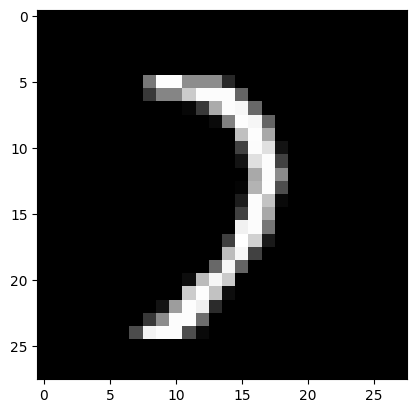

In [14]:
from matplotlib import pyplot as plt

plt.imshow(image.reshape(28,28).numpy(),cmap='gray')
plt.show()